In [20]:
import pandas as pd
import ast 
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
monthly_openai_embed_path = "../../data/proc/embeddings/monthly_openai_emb_wide.csv"
daily_openai_embed_path = "../../data/proc/embeddings/daily_openai_emb_long.csv"

In [23]:
monthly_cols = [
    "ParticipantIdentifier",
    "trial_date",
    "MONTHLY_goal_set1",
    "MONTHLY_goal_set2",
    "monthly_emb1",
    "monthly_emb2"
]

monthly_emb = pd.read_csv(monthly_openai_embed_path)[monthly_cols]

In [24]:
daily_emb = pd.read_csv(daily_openai_embed_path)
daily_emb = daily_emb.pivot_table(
    index=['ParticipantIdentifier', 'trial_date'],
    columns='ResultIdentifier',
    values='emb',
    aggfunc='first'
).reset_index(drop=False)
daily_emb.head(2)

ResultIdentifier,ParticipantIdentifier,trial_date,DAILY_goal1_set,DAILY_goal2_set
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.04656229913234711, 0.0007934867171570659, ..."
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.014762434177100658, 0.02009924314916134, -..."


In [25]:
print("Number of columns in daily dataset is: ", len(daily_emb))
print("Number of columns in monthly dataset is:", len(monthly_emb))

Number of columns in daily dataset is:  7788
Number of columns in monthly dataset is: 466


In [26]:
monthly_emb["trial_date"] = pd.to_datetime(monthly_emb["trial_date"])
monthly_emb = monthly_emb.sort_values(["ParticipantIdentifier", "trial_date"]).reset_index(drop=True)

In [27]:
daily_emb["trial_date"] = pd.to_datetime(daily_emb["trial_date"])
daily_emb = daily_emb.sort_values(["ParticipantIdentifier", "trial_date"]).reset_index(drop=True)

In [28]:
print("Number of columns in daily dataset is: ", len(daily_emb))
print("Number of columns in monthly dataset is:", len(monthly_emb))

Number of columns in daily dataset is:  7788
Number of columns in monthly dataset is: 466


In [29]:
def get_participant_month_label(pid, date, monthly_emb,
                                pid_col="ParticipantIdentifier",
                                date_col="trial_date",
                                label_col="month_number"):
    """
    Return the 'label_col' of the first row whose date is AFTER 'date',
    but only if 'date' is strictly between the previous and current row's dates.

    Example logic: if rows[i-1].date < date < rows[i].date → return rows[i].label
    """
    # Filter to this participant and ensure chronological order
    rows = (monthly_emb.loc[monthly_emb[pid_col] == pid]
                        .sort_values(date_col)
                        .reset_index(drop=True))
    # Walk adjacent pairs
    for i in range(1, len(rows)):
        prev_date = rows.iloc[i - 1][date_col]
        curr_date = rows.iloc[i][date_col]
        if prev_date < date < curr_date:
            return rows.iloc[i - 1][label_col]
        
        if i == 2 and date > curr_date:
            return rows.iloc[i][label_col]

    return None

In [30]:
monthly_emb["month_number"] = (
    monthly_emb.groupby("ParticipantIdentifier").cumcount().add(1)
)

In [31]:
monthly_emb.head(3)

,ParticipantIdentifier,trial_date,MONTHLY_goal_set1,MONTHLY_goal_set2,monthly_emb1,monthly_emb2,month_number
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",1
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-28,Be consistent with exercise,Have a consistent sleep and study schedule,"[0.009357095696032047, 0.025285957381129265, -...","[0.0017548769246786833, 0.021520286798477173, ...",2
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-03-28,Apply to jobs,Prepare for exams,"[-0.04386921972036362, -0.008735968731343746, ...","[-0.04361158609390259, 0.032396212220191956, -...",3


In [32]:
daily_emb["month_number"] = daily_emb.apply(lambda x: get_participant_month_label(
    x["ParticipantIdentifier"], x["trial_date"], monthly_emb,
    pid_col="ParticipantIdentifier",
    date_col="trial_date",
    label_col="month_number"), axis=1
)

In [33]:
merged = daily_emb.merge(monthly_emb, on = ['ParticipantIdentifier', 'month_number'], how='inner')
print(len(merged))

7401


In [37]:
merged = merged.rename(columns={
    "trial_date_x": "trial_date",
    "trial_date_y": "monthly_goal_set_date",
    "MONTHLY_goal_set1": "MONTHLY_goal_1",
    "MONTHLY_goal_set2": "MONTHLY_goal_2",
    "DAILY_goal1_set": "daily_emb1",
    "DAILY_goal2_set": "daily_emb2"
})

In [38]:
merged = merged.dropna()

In [39]:
merged.head()

,ParticipantIdentifier,trial_date,daily_emb1,daily_emb2,month_number,monthly_goal_set_date,MONTHLY_goal_1,MONTHLY_goal_2,monthly_emb1,monthly_emb2
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.04656229913234711, 0.0007934867171570659, ...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ..."
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.014762434177100658, 0.02009924314916134, -...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ..."
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,"[-0.03221265226602554, -0.010712618008255959, ...","[0.007794945500791073, 0.014498291537165642, -...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ..."
3,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-04,"[-0.0068207005970180035, 0.024796752259135246,...","[-0.012282999232411385, 0.016515225172042847, ...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ..."
4,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-05,"[-0.0068207005970180035, 0.024796752259135246,...","[-0.007066924124956131, -0.026265734806656837,...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ..."


In [40]:
print(len(merged))

7401


In [41]:
cols = ["daily_emb1", "daily_emb2", "monthly_emb1", "monthly_emb2"]

for c in cols:
    merged[c] = merged[c].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [42]:
merged = merged.dropna()
merged.head(3)

,ParticipantIdentifier,trial_date,daily_emb1,daily_emb2,month_number,monthly_goal_set_date,MONTHLY_goal_1,MONTHLY_goal_2,monthly_emb1,monthly_emb2
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.04656229913234711, 0.0007934867171570659, ...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ..."
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.014762434177100658, 0.02009924314916134, -...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ..."
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,"[-0.03221265226602554, -0.010712618008255959, ...","[0.007794945500791073, 0.014498291537165642, -...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ..."


In [45]:
def cosine(u, v):
    # print(u, v)
    u = np.asarray(u, dtype=float)
    v = np.asarray(v, dtype=float)
    nu = np.linalg.norm(u); nv = np.linalg.norm(v)
    if nu == 0 or nv == 0: 
        return np.nan
    return float(np.dot(u, v) / (nu * nv))

def get_max_similarity(row):
    a = cosine(row["daily_emb1"], row["monthly_emb1"])
    b = cosine(row["daily_emb1"], row["monthly_emb2"])
    c = cosine(row["daily_emb2"], row["monthly_emb1"])
    d = cosine(row["daily_emb2"], row["monthly_emb2"])
    return max(a, b, c, d)

In [51]:
merged["daily_monthly_sim"] = merged.apply(lambda x: get_max_similarity(x), axis=1)

In [52]:
pid   = "ParticipantIdentifier"
month = "month_number"
date  = "trial_date"          # or use 'entry_no' if you already have it
sim   = "daily_monthly_sim"     # note the hyphens → use bracket access

df = merged.copy()

# ensure correct ordering inside each (participant, month) group
df[date] = pd.to_datetime(df[date], errors="coerce")
df = df.sort_values([pid, month, date], kind="stable")

df["day_since_month_start"] = (df["trial_date"] - df["monthly_goal_set_date"]).dt.days
df.head()

,ParticipantIdentifier,trial_date,daily_emb1,daily_emb2,month_number,monthly_goal_set_date,MONTHLY_goal_1,MONTHLY_goal_2,monthly_emb1,monthly_emb2,daily-monthly-sim,daily_monthly_sim,day_since_month_start
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.04656229913234711, 0.0007934867171570659, ...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",0.442575,0.442575,2
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.014762434177100658, 0.02009924314916134, -...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",0.424231,0.424231,3
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,"[-0.03221265226602554, -0.010712618008255959, ...","[0.007794945500791073, 0.014498291537165642, -...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",0.445251,0.445251,4
3,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-04,"[-0.0068207005970180035, 0.024796752259135246,...","[-0.012282999232411385, 0.016515225172042847, ...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",0.572936,0.572936,5
4,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-05,"[-0.0068207005970180035, 0.024796752259135246,...","[-0.007066924124956131, -0.026265734806656837,...",1.0,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",0.248102,0.248102,6


In [54]:
# sns.lmplot(data=df, 
#            x="day_since_month_start", 
#            y="daily_monthly_sim", 
#            hue="ParticipantIdentifier",
#            lowess=True, scatter=False, aspect=1.5)

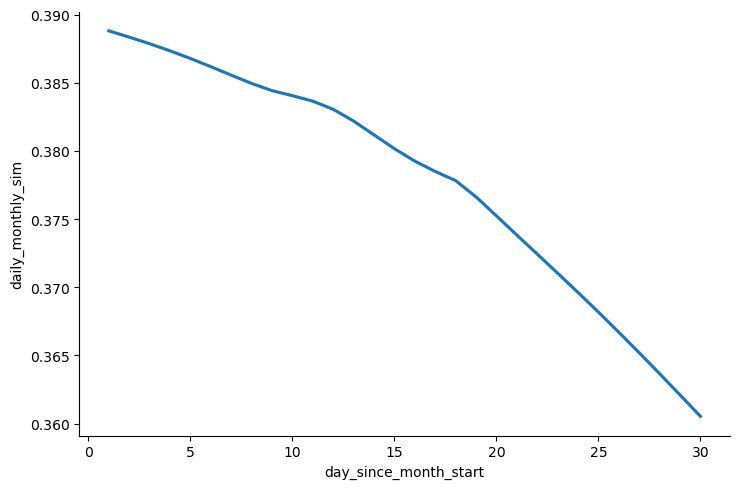

In [55]:
sns.lmplot(data=df, 
           x="day_since_month_start", 
           y="daily_monthly_sim", 
           lowess=True, scatter=False, aspect=1.5)

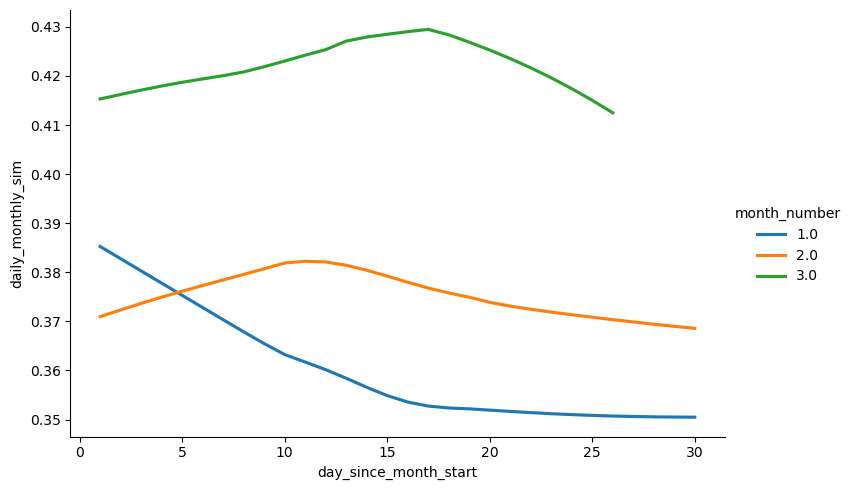

In [56]:
sns.lmplot(
    data=df,
    x="day_since_month_start",
    y="daily_monthly_sim",
    hue="month_number",
    lowess=True,
    scatter=False,
    aspect=1.5
)

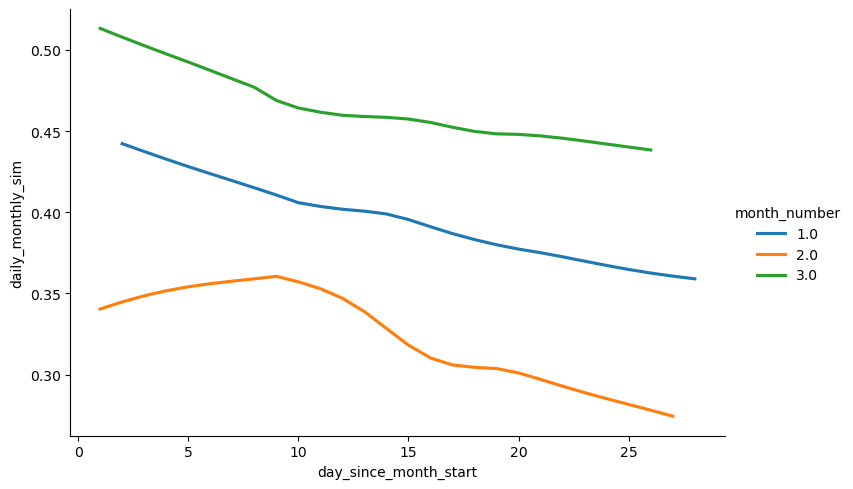

In [59]:
sns.lmplot(
    data=df.loc[df["ParticipantIdentifier"] == "0151d9f1-1644-4437-805e-02f5e244a690"],
    x="day_since_month_start",
    y="daily_monthly_sim",
    hue="month_number",
    lowess=True,
    scatter=False,
    aspect=1.5
)

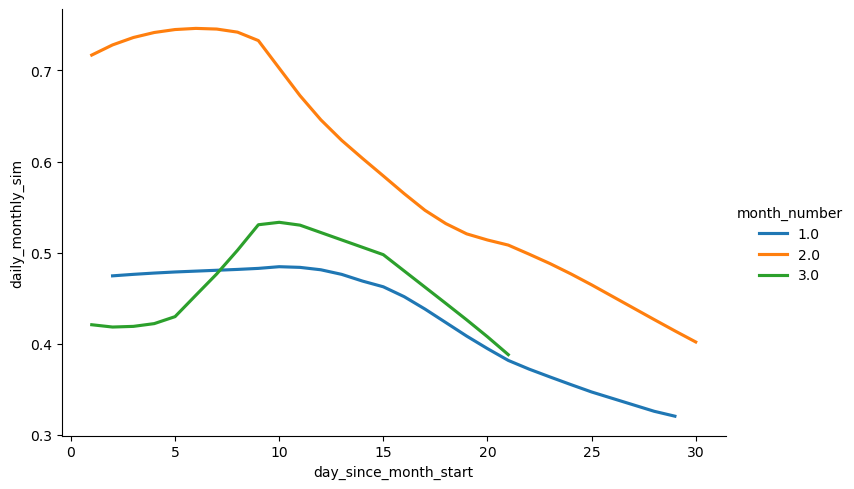

In [63]:
sns.lmplot(
    data=df.loc[df["ParticipantIdentifier"] == "146e1ab8-c4ca-4a52-9261-e108b38eea53"],
    x="day_since_month_start",
    y="daily_monthly_sim",
    hue="month_number",
    lowess=True,
    scatter=False,
    aspect=1.5
)

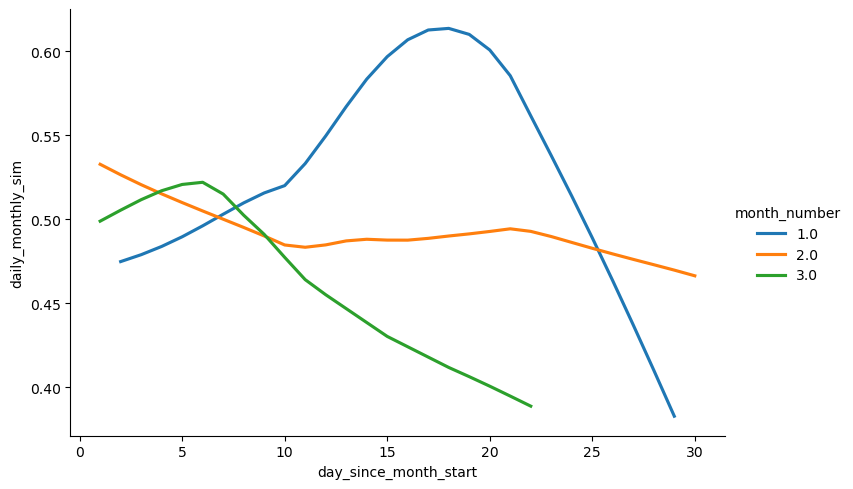

In [62]:


sns.lmplot(
    data=df.loc[df["ParticipantIdentifier"] == "0ca43379-41b5-47fb-90ba-0a22e6bf5586"],
    x="day_since_month_start",
    y="daily_monthly_sim",
    hue="month_number",
    lowess=True,
    scatter=False,
    aspect=1.5
)

# 0ca43379-41b5-47fb-90ba-0a22e6bf5586

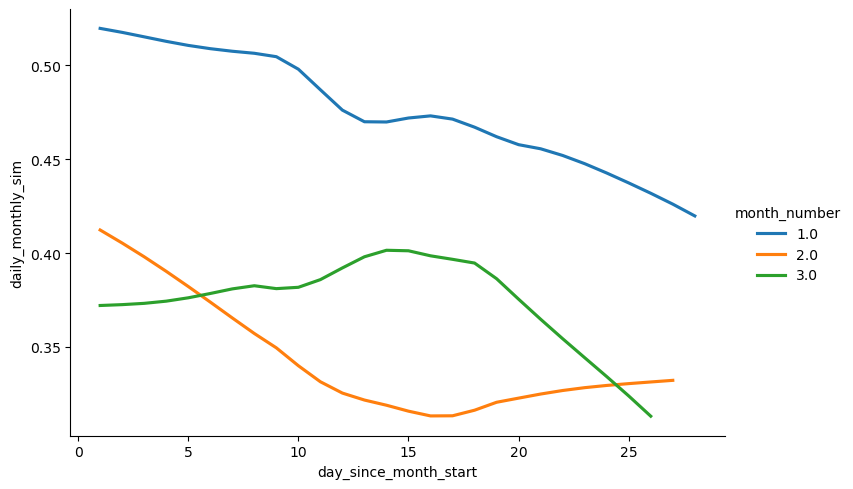

In [64]:
sns.lmplot(
    data=df.loc[df["ParticipantIdentifier"] == "08e76051-ee6e-4872-896f-4ed3857afc0f"],
    x="day_since_month_start",
    y="daily_monthly_sim",
    hue="month_number",
    lowess=True,
    scatter=False,
    aspect=1.5
)